In [100]:
#Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        unique_labels = np.unique(y)

        if len(unique_labels) == 1 or (self.max_depth and depth >= self.max_depth):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y, num_features)

        if best_feature is None:
            return Node(value=self._most_common_label(y))

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

         #Check if we have data to send for left or right child
        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1) if len(y[left_indices]) > 0 else Node(value=self._most_common_label(y)) #Handles empty left splits
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1) if len(y[right_indices]) > 0 else Node(value=self._most_common_label(y)) #Handles empty right splits

        return Node(best_feature, best_threshold, left_subtree, right_subtree)

    def _best_split(self, X, y, num_features):
        best_entropy = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                entropy = self._entropy_impurity(X[:, feature], y, threshold)
                if entropy < best_entropy:
                    best_entropy = entropy
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _entropy_impurity(self, feature_column, y, threshold):
        left_indices = feature_column <= threshold
        right_indices = ~left_indices

        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])

        left_weight = np.sum(left_indices) / len(y)
        right_weight = np.sum(right_indices) / len(y)

        return left_weight * left_entropy + right_weight * right_entropy

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))

    def _most_common_label(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [102]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
# print('Datasets have been downloaded.')

In [103]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [104]:
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [105]:
# (a) KDD Cup '99

# Setting column names from dataset description
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()

print(df.shape)

(145586, 42)


In [106]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [113]:
# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 80% train, 20% test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Accuracy: 99.87%
Precision: 0.9990
Recall: 0.9977
F1 Score: 0.9983


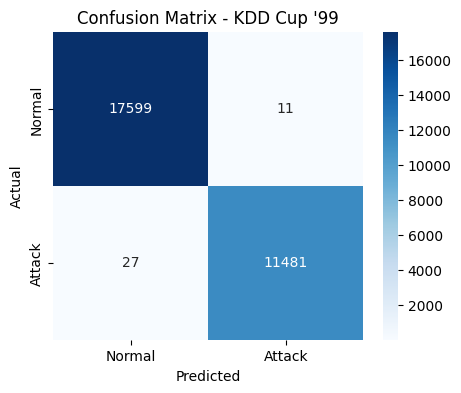

In [108]:
# Train and evaluate the Decision Tree model
dt = DecisionTree(max_depth=10)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute accuracy
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - KDD Cup '99" )

Model Accuracy: 99.76%
Precision: 0.9990
Recall: 0.9950
F1 Score: 0.9970


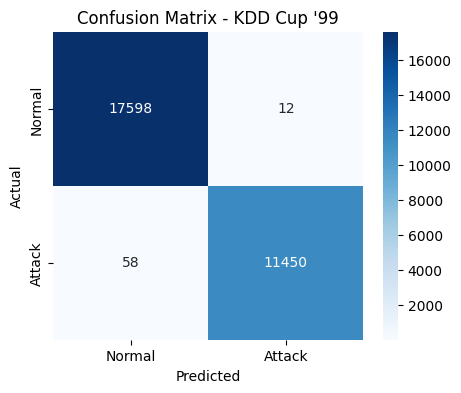

In [109]:
#comparing with sklearn
dt_clf = DecisionTreeClassifier(max_depth=10)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - KDD Cup '99")


In [110]:
#(b) ON the NSL-KDD Dataset
KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None)
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

#Dropping the difficulty column as its irrelevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a
#Clearly, we can see that this daataset is more balanced

# Label encode categorical columns(to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)

# Split features and labels
X_train = train_df.drop("class", axis=1).values
y_train = train_df["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)
{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
(125973, 41)
(22544, 41)

{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
(125973, 41)
(22544, 41)


(22544, 41)

Model Accuracy: 82.68%
Precision: 0.9708
Recall: 0.7173
F1 Score: 0.8250


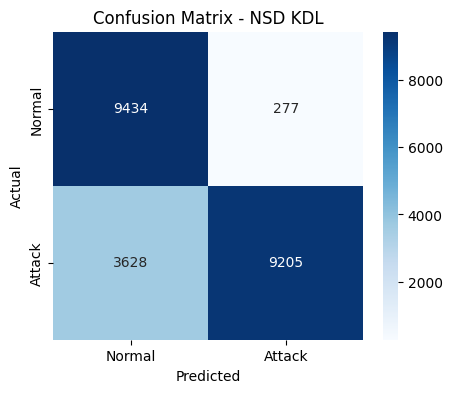

In [111]:
# Train and evaluate the Decision Tree model
dt = DecisionTree(max_depth=10)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute accuracy
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - NSD KDL" )

Model Accuracy: 77.39%
Precision: 0.9670
Recall: 0.6241
F1 Score: 0.7586


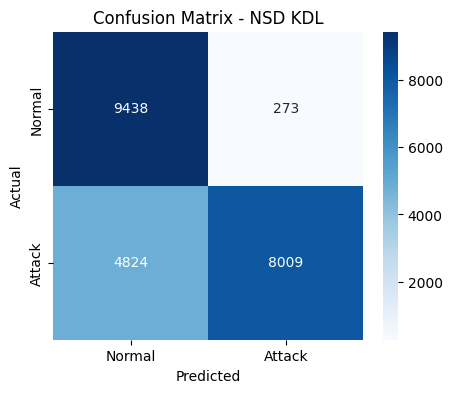

In [112]:
#comparing with sklearn
dt_clf = DecisionTreeClassifier(max_depth=10)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - NSD KDL")
